Importamos librerias

In [1]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot

Funcion de One Hot Encoder

In [2]:
# Archivo utilizado para crear la función de One Hot Encoding
############################################################# 

# Función auxiliar: Toma un df de variables categoricas y selección el top_x de categorias
def one_hot_top_x(cat_df, variable,top_x_labels):
    for label in top_x_labels:
        cat_df[str(variable)+'_'+str(label)] = np.where(cat_df[variable]==label,1,0)

# Función One Hot Encoder: Toma un DF y le hace una transformación de One Hot Encoder para con las categorias más repetidas 
def one_hot_encoder(df,top_x):
    # Separo variables categoricas de númericas
    num_cols = df.select_dtypes(include=['float64', 'int']).columns.to_list()
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.to_list()
    
    # Armo un DF solo con variables categoricas
    cat_df = df.drop(num_cols,axis=1)
    # Armo un DF solo con variables categoricas
    num_df = df.drop(cat_cols,axis=1)
   
    # Itero entre las variables categoricas y me quedo con el top 10 variables
    for variable in cat_cols:
        top_10 = [x for x in cat_df[variable].value_counts().sort_values(ascending=False).head(top_x).index]
        one_hot_top_x(cat_df,variable,top_10)
    
    cat_df = cat_df.drop(cat_cols,axis=1)
    df = pd.concat([cat_df,num_df], axis =1)
    
    return df

Importamos datos

In [3]:
# Levantamos los datos procesados
datos_meli = pd.read_excel('data_ready_to_model_api_completa.xlsx')

# Los paso por One Hot Encoder
datos_meli = one_hot_encoder(datos_meli,100)

C:\Users\LUCIA~1.LOP\AppData\Local\Temp/ipykernel_17748/187505526.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  cat_df[str(variable)+'_'+str(label)] = np.where(cat_df[variable]==label,1,0)


Separamos en Train & Test

In [4]:
#separate the other attributes from the predicting attribute
x = datos_meli.drop('price',axis=1)

#separte the predicting attribute into Y for model training 
y = datos_meli['price']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

Entrenamos el modelo

In [ ]:
# Modelo Simple

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.7999999999999999, learning_rate = 0.1,
                max_depth = 6, alpha = 10, n_estimators = 1000, colsample_bylevel =  0.6, subsample = 0.8999999999999999)
xg_reg.fit(X_train,y_train)

Miramos resultados

In [16]:
y_pred = xg_reg.predict(X_test)

print('MAE: Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred)/1000,2))
print('MSE: Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred)/1000,2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/1000,2))


MAE: Mean Absolute Error: 264.39
MSE: Mean Squared Error: 182492048.23
Root Mean Squared Error: 427.19


Text(0.5, 1.0, 'Feature Importance')

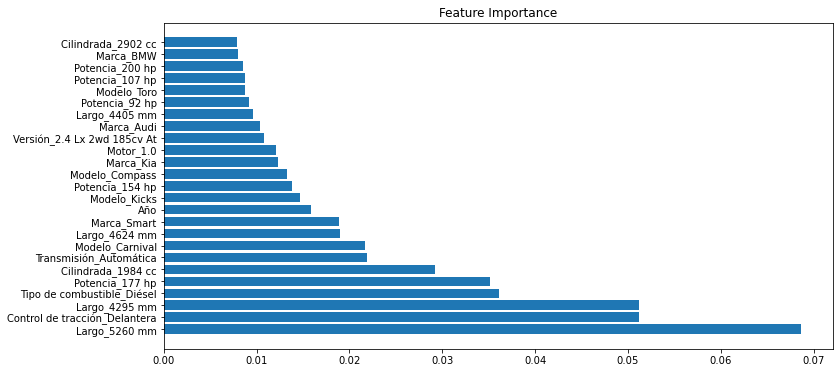

In [17]:
# Miro la importancia de las variables

feature_importance = xg_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(0,25), feature_importance[sorted_idx][::-1][:25], align='center')
plt.yticks(range(0,25), np.array(X_test.columns)[sorted_idx][::-1][:25])
plt.title('Feature Importance')

Optimizamos parametros

In [ ]:
########################################## Optimizando los hiperparametros
########################################## GridSearchCV

params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 300, 500],
           'colsample_bytree': [0.3, 0.7]}

xgbr = xgb.XGBRegressor(seed = 20)
clf_GS = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring = 'neg_mean_absolute_error',
                   verbose=1)

clf_GS.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)

y_pred_test = clf_GridS.best_estimator_(X_test)
y_pred_train = clf_GridS.best_estimator_(X_train)

print('MAE: Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred)/1000000,2))
print('MSE: Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred)/1000000,2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/1000000,2))


# Para ver overfitting
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))/1000000,2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train))/1000000,2))
print("Lowest RMSE: ", round(((-clf_GridS.best_score_)**(1/2.0)/1000000),2))
print("Lowest MSE: ", round((-clf_GridS.best_score_/1000000),2))


In [ ]:
best_estimator_.feature_importances_

In [ ]:
########################################## RandomSearch

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000],
           'eta': [0.3, 0.01, 0.2]
           'min_child_weight': [1, 2, 3]}

xgbr = xgb.XGBRegressor(seed = 20)
clf_RandomS = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=3,
                         verbose=1)
clf_RandomS.fit(X_train, y_train)

In [8]:
print("Best parameters:", clf_RandomS.best_params_)
print("Lowest RMSE: ", round(((-clf_RandomS.best_score_)**(1/2.0)/1000),2))
print("Lowest MSE: ", round((-clf_RandomS.best_score_/1000),2))

Best parameters: {'subsample': 0.8999999999999999, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7}
Lowest RMSE:  670.22
Lowest MSE:  449197906.37


In [ ]:
# Miro la importancia de las variables

feature_importance = best_score_.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(0,25), feature_importance[sorted_idx][::-1][:25], align='center')
plt.yticks(range(0,25), np.array(X_train.columns)[sorted_idx][::-1][:25])
plt.title('Feature Importance')

In [65]:
print('MAE: Mean Absolute Error:', round(metrics.mean_absolute_error(y_test, y_pred)/1000,2))
print('MSE: Mean Squared Error:', round(metrics.mean_squared_error(y_test, y_pred)/1000,2))
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/1000,2))


MAE: Mean Absolute Error: 1222.77
MSE: Mean Squared Error: 2678243957.98
Root Mean Squared Error: 1636.53
